Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
import joblib
from typing import Tuple
import warnings
from scipy import stats
from scipy.fft import fft
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Data Loading and Batching

In [2]:
# class DataLoader:
#     def __init__(self, train_split, random_state, batch_size):
#         self.train_split = train_split
#         self.random_state = random_state
#         self.batch_size = batch_size
#         self.all_data = None
#         self.all_labels = None
#         self.file_metadata = None
#         self.train_files = None
#         self.test_files = None
#         self.train_batches = None
#         self.test_batches = None
#         self.train_batch_labels = None
#         self.test_batch_labels = None

#     def load_all_data(self, train_dir: str, test_dir: str) -> None:
#         all_file_data = {}
        
#         for directory, dir_type in [(train_dir, 'original_train'), (test_dir, 'original_test')]:
#             if not os.path.exists(directory):
#                 continue

#             for folder in sorted(os.listdir(directory)):
#                 folder_path = os.path.join(directory, folder)
#                 if not os.path.isdir(folder_path):
#                     continue

#                 for file in os.listdir(folder_path):
#                     if not file.endswith('.csv'):
#                         continue

#                     file_path = os.path.join(folder_path, file)
#                     df = pd.read_csv(file_path, encoding="ISO-8859-1")
#                     file_id = f"{dir_type}_{folder}_{file.replace('.csv', '')}"
                    
#                     all_file_data[file_id] = {
#                         'data': df,
#                         'label': folder,
#                         'file_path': file_path,
#                         'original_source': dir_type,
#                         'activity': folder
#                     }

#         self.file_metadata = all_file_data
#         print(f"Total files: {len(self.file_metadata)}")
#         print(f"Activities: {sorted(set([meta['activity'] for meta in self.file_metadata.values()]))}")
        
#         self._analyze_file_distribution()
#         self._create_batches()

#     def _analyze_file_distribution(self):
#         print("\nFile distribution per activity:")
#         activity_stats = {}
        
#         for file_id, meta in self.file_metadata.items():
#             activity = meta['activity']
#             if activity not in activity_stats:
#                 activity_stats[activity] = {'files': 0, 'total_samples': 0}
            
#             activity_stats[activity]['files'] += 1
#             activity_stats[activity]['total_samples'] += len(meta['data'])
        
#         for activity in sorted(activity_stats.keys()):
#             stats = activity_stats[activity]
#             print(f"{activity}: {stats['files']} files, {stats['total_samples']} samples")
        
#         total_files = sum([stats['files'] for stats in activity_stats.values()])
#         total_samples = sum([stats['total_samples'] for stats in activity_stats.values()])
#         print(f"Total: {total_files} files, {total_samples} samples")

#     def _create_batches(self):
#         print(f"\nCreating batches with batch_size={self.batch_size}")
        
#         all_batches = []
#         all_batch_labels = []
#         batch_file_mapping = []
        
#         for file_id, meta in self.file_metadata.items():
#             df = meta['data'].copy()
#             label = meta['label']
            
#             cols_to_exclude = ['Unnamed: 0', 'time', 'target']
#             feature_cols = [col for col in df.columns if col not in cols_to_exclude]

#             features = df[feature_cols].dropna()
            
#             if len(features) == 0:
#                 continue
            
#             n_complete_batches = len(features) // self.batch_size
            
#             if n_complete_batches == 0:
#                 print(f"File {file_id}: {len(features)} samples - No complete batches (skipped)")
#                 continue
            
#             print(f"File {file_id}: {len(features)} samples -> {n_complete_batches} batches")
            
#             for batch_idx in range(n_complete_batches):
#                 start_idx = batch_idx * self.batch_size
#                 end_idx = start_idx + self.batch_size
                
#                 batch_data = features.iloc[start_idx:end_idx].values
#                 aggregated_batch = np.concatenate([
#                         np.mean(batch_data, axis=0),
#                         np.std(batch_data, axis=0),
#                         np.min(batch_data, axis=0),
#                         np.max(batch_data, axis=0)
#                 ])
                
#                 all_batches.append(aggregated_batch)
#                 all_batch_labels.append(label)
#                 batch_file_mapping.append(file_id)
        
#         self.all_batches = np.array(all_batches)
#         self.all_batch_labels = np.array(all_batch_labels)
#         self.batch_file_mapping = batch_file_mapping
        
#         print(f"\nTotal batches created: {len(self.all_batches)}")
#         print(f"Batch feature dimension: {self.all_batches.shape[1] if len(self.all_batches) > 0 else 0}")

#     def split_by_files(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#         if self.all_batches is None or len(self.all_batches) == 0:
#             raise ValueError("No batches created. Check if data was loaded properly.")

#         all_files = list(self.file_metadata.keys())
#         np.random.seed(self.random_state)
#         np.random.shuffle(all_files)

#         n_train_files = int(len(all_files) * self.train_split)
#         self.train_files = all_files[:n_train_files]
#         self.test_files = all_files[n_train_files:]

#         print(f"\nTrain files: {len(self.train_files)}")
#         print(f"Test files: {len(self.test_files)}")

#         train_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.train_files]
#         test_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.test_files]

#         X_train = self.all_batches[train_indices]
#         X_test = self.all_batches[test_indices]
#         y_train = self.all_batch_labels[train_indices]
#         y_test = self.all_batch_labels[test_indices]

#         self.train_batches = X_train
#         self.test_batches = X_test
#         self.train_batch_labels = y_train
#         self.test_batch_labels = y_test

#         print(f"Train batches: {len(X_train)}")
#         print(f"Test batches: {len(X_test)}")

#         self._check_activity_distribution_batches(train_indices, test_indices)

#         return X_train, X_test, y_train, y_test

#     def _check_activity_distribution_batches(self, train_indices, test_indices):
#         train_activities = set(self.all_batch_labels[train_indices])
#         test_activities = set(self.all_batch_labels[test_indices])
#         all_activities = set(self.all_batch_labels)

#         print(f"Train activities: {sorted(train_activities)}")
#         print(f"Test activities: {sorted(test_activities)}")

#         if all_activities - train_activities:
#             print(f"Missing in train: {sorted(all_activities - train_activities)}")
#         if all_activities - test_activities:
#             print(f"Missing in test: {sorted(all_activities - test_activities)}")

#         print("\nBatch distribution per activity:")
#         for activity in sorted(all_activities):
#             train_count = np.sum(self.all_batch_labels[train_indices] == activity)
#             test_count = np.sum(self.all_batch_labels[test_indices] == activity)
#             print(f"{activity}: {train_count} train batches, {test_count} test batches")

#     def load_data(self, root_dir: str) -> Tuple[np.ndarray, np.ndarray]:
#         if root_dir.lower() == 'train':
#             if self.train_batches is None:
#                 raise ValueError("Call get_train_test_split first.")
#             return self.train_batches, self.train_batch_labels
#         elif root_dir.lower() == 'test':
#             if self.test_batches is None:
#                 raise ValueError("Call get_train_test_split first.")
#             return self.test_batches, self.test_batch_labels
#         else:
#             raise ValueError("Invalid root_dir. Use 'train' or 'test'.")

#     def get_train_test_split(self, train_dir: str = 'data_received_/recorded_data_12344', test_dir: str = 'data_received_/recorded_data_12345') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#         self.load_all_data(train_dir, test_dir)
#         return self.split_by_files()

# loader = DataLoader(train_split=0.8, random_state=38, batch_size=51)
# X_train_batches, X_test_batches, y_train_batches, y_test_batches = loader.get_train_test_split('data_received/recorded_data_12344', 'data_received/recorded_data_12345')

# print(f"\nFinal Results:")
# print(f"Train batches shape: {X_train_batches.shape}")
# print(f"Test batches shape: {X_test_batches.shape}")
# print(f"Features per batch: {X_train_batches.shape[1] if len(X_train_batches) > 0 else 0}")
# print(f"Classes: {len(np.unique(y_train_batches)) if len(y_train_batches) > 0 else 0}")

Total files: 136
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 16 files, 15347 samples
with_hook_climbing_up: 24 files, 12223 samples
with_hook_descending_down: 25 files, 14334 samples
without_hook_climbing_up: 36 files, 14405 samples
without_hook_descending_down: 35 files, 13548 samples
Total: 136 files, 69857 samples

Creating batches with batch_size=51
File original_train_idle_18062025_114823_12344_2: 594 samples -> 11 batches
File original_train_idle_18062025_114949_12344_3: 835 samples -> 16 batches
File original_train_idle_18062025_115127_12344_4: 1290 samples -> 25 batches
File original_train_idle_18062025_115503_12344_5: 835 samples -> 16 batches
File original_train_idle_18062025_115754_12344_6: 1076 samples -> 21 batches
File original_train_idle_18062025_121814_12344_7: 737 samples -> 14 batches
File original_train_idle_18062025_141135_12344_7: 710 sa

In [19]:
class DataLoader:
    def __init__(self, train_split, random_state, batch_size):
        self.train_split = train_split
        self.random_state = random_state
        self.batch_size = batch_size
        self.all_data = None
        self.all_labels = None
        self.file_metadata = None
        self.train_files = None
        self.test_files = None
        self.train_batches = None
        self.test_batches = None
        self.train_batch_labels = None
        self.test_batch_labels = None

    def load_all_data(self, train_dir: str, test_dir: str) -> None:
        all_file_data = {}
        
        for directory, dir_type in [(train_dir, 'original_train'), (test_dir, 'original_test')]:
            if not os.path.exists(directory):
                continue

            for folder in sorted(os.listdir(directory)):
                folder_path = os.path.join(directory, folder)
                if not os.path.isdir(folder_path):
                    continue

                for file in os.listdir(folder_path):
                    if not file.endswith('.csv'):
                        continue

                    file_path = os.path.join(folder_path, file)
                    df = pd.read_csv(file_path, encoding="ISO-8859-1")
                    file_id = f"{dir_type}_{folder}_{file.replace('.csv', '')}"
                    
                    all_file_data[file_id] = {
                        'data': df,
                        'label': folder,
                        'file_path': file_path,
                        'original_source': dir_type,
                        'activity': folder
                    }

        self.file_metadata = all_file_data
        print(f"Total files: {len(self.file_metadata)}")
        print(f"Activities: {sorted(set([meta['activity'] for meta in self.file_metadata.values()]))}")
        
        self._analyze_file_distribution()
        self._create_batches()

    def _analyze_file_distribution(self):
        print("\nFile distribution per activity:")
        activity_stats = {}
        
        for file_id, meta in self.file_metadata.items():
            activity = meta['activity']
            if activity not in activity_stats:
                activity_stats[activity] = {'files': 0, 'total_samples': 0}
            
            activity_stats[activity]['files'] += 1
            activity_stats[activity]['total_samples'] += len(meta['data'])
        
        for activity in sorted(activity_stats.keys()):
            stats = activity_stats[activity]
            print(f"{activity}: {stats['files']} files, {stats['total_samples']} samples")
        
        total_files = sum([stats['files'] for stats in activity_stats.values()])
        total_samples = sum([stats['total_samples'] for stats in activity_stats.values()])
        print(f"Total: {total_files} files, {total_samples} samples")

    def _create_batches(self):
        print(f"\nCreating batches with batch_size={self.batch_size}")
        
        all_batches = []
        all_batch_labels = []
        batch_file_mapping = []
        
        for file_id, meta in self.file_metadata.items():
            df = meta['data'].copy()
            label = meta['label']
            
            cols_to_exclude = ['Unnamed: 0', 'time', 'target']
            feature_cols = [col for col in df.columns if col not in cols_to_exclude]

            # === Apply pressure difference to 'p' column ===
            if 'p' in feature_cols:
                df['p'] = df['p'].diff().fillna(0)

            features = df[feature_cols].dropna()
            if len(features) == 0:
                continue
            
            n_complete_batches = len(features) // self.batch_size
            if n_complete_batches == 0:
                print(f"File {file_id}: {len(features)} samples - No complete batches (skipped)")
                continue
            
            print(f"File {file_id}: {len(features)} samples -> {n_complete_batches} batches")
            
            for batch_idx in range(n_complete_batches):
                start_idx = batch_idx * self.batch_size
                end_idx = start_idx + self.batch_size
                
                batch_data = features.iloc[start_idx:end_idx].values

                # Ensure pressure difference is preserved across batches
                if batch_data.shape[1] >= 1:  # only if there is a pressure column
                    batch_data[:, -1] = np.append(0, np.diff(batch_data[:, -1]))

                aggregated_batch = np.concatenate([
                    np.mean(batch_data, axis=0),
                    np.std(batch_data, axis=0),
                    np.min(batch_data, axis=0),
                    np.max(batch_data, axis=0)
                ])
                
                all_batches.append(aggregated_batch)
                all_batch_labels.append(label)
                batch_file_mapping.append(file_id)
        
        self.all_batches = np.array(all_batches)
        self.all_batch_labels = np.array(all_batch_labels)
        self.batch_file_mapping = batch_file_mapping
        
        print(f"\nTotal batches created: {len(self.all_batches)}")
        print(f"Batch feature dimension: {self.all_batches.shape[1] if len(self.all_batches) > 0 else 0}")

    def split_by_files(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        if self.all_batches is None or len(self.all_batches) == 0:
            raise ValueError("No batches created. Check if data was loaded properly.")

        all_files = list(self.file_metadata.keys())
        np.random.seed(self.random_state)
        np.random.shuffle(all_files)

        n_train_files = int(len(all_files) * self.train_split)
        self.train_files = all_files[:n_train_files]
        self.test_files = all_files[n_train_files:]

        print(f"\nTrain files: {len(self.train_files)}")
        print(f"Test files: {len(self.test_files)}")

        train_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.train_files]
        test_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.test_files]

        X_train = self.all_batches[train_indices]
        X_test = self.all_batches[test_indices]
        y_train = self.all_batch_labels[train_indices]
        y_test = self.all_batch_labels[test_indices]

        self.train_batches = X_train
        self.test_batches = X_test
        self.train_batch_labels = y_train
        self.test_batch_labels = y_test

        print(f"Train batches: {len(X_train)}")
        print(f"Test batches: {len(X_test)}")

        self._check_activity_distribution_batches(train_indices, test_indices)

        return X_train, X_test, y_train, y_test

    def _check_activity_distribution_batches(self, train_indices, test_indices):
        train_activities = set(self.all_batch_labels[train_indices])
        test_activities = set(self.all_batch_labels[test_indices])
        all_activities = set(self.all_batch_labels)

        print(f"Train activities: {sorted(train_activities)}")
        print(f"Test activities: {sorted(test_activities)}")

        if all_activities - train_activities:
            print(f"Missing in train: {sorted(all_activities - train_activities)}")
        if all_activities - test_activities:
            print(f"Missing in test: {sorted(all_activities - test_activities)}")

        print("\nBatch distribution per activity:")
        for activity in sorted(all_activities):
            train_count = np.sum(self.all_batch_labels[train_indices] == activity)
            test_count = np.sum(self.all_batch_labels[test_indices] == activity)
            print(f"{activity}: {train_count} train batches, {test_count} test batches")

    def load_data(self, root_dir: str) -> Tuple[np.ndarray, np.ndarray]:
        if root_dir.lower() == 'train':
            if self.train_batches is None:
                raise ValueError("Call get_train_test_split first.")
            return self.train_batches, self.train_batch_labels
        elif root_dir.lower() == 'test':
            if self.test_batches is None:
                raise ValueError("Call get_train_test_split first.")
            return self.test_batches, self.test_batch_labels
        else:
            raise ValueError("Invalid root_dir. Use 'train' or 'test'.")

    def get_train_test_split(self, train_dir: str = 'data_received_/recorded_data_12344', test_dir: str = 'data_received_/recorded_data_12345') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        self.load_all_data(train_dir, test_dir)
        return self.split_by_files()

loader = DataLoader(train_split=0.8, random_state=38, batch_size=51)
X_train_batches, X_test_batches, y_train_batches, y_test_batches = loader.get_train_test_split('data_received/recorded_data_12344', 'data_received/recorded_data_12345')

print(f"\nFinal Results:")
print(f"Train batches shape: {X_train_batches.shape}")
print(f"Test batches shape: {X_test_batches.shape}")
print(f"Features per batch: {X_train_batches.shape[1] if len(X_train_batches) > 0 else 0}")
print(f"Classes: {len(np.unique(y_train_batches)) if len(y_train_batches) > 0 else 0}")

Total files: 136
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 16 files, 15347 samples
with_hook_climbing_up: 24 files, 12223 samples
with_hook_descending_down: 25 files, 14334 samples
without_hook_climbing_up: 36 files, 14405 samples
without_hook_descending_down: 35 files, 13548 samples
Total: 136 files, 69857 samples

Creating batches with batch_size=51
File original_train_idle_18062025_114823_12344_2: 594 samples -> 11 batches
File original_train_idle_18062025_114949_12344_3: 835 samples -> 16 batches
File original_train_idle_18062025_115127_12344_4: 1290 samples -> 25 batches
File original_train_idle_18062025_115503_12344_5: 835 samples -> 16 batches
File original_train_idle_18062025_115754_12344_6: 1076 samples -> 21 batches
File original_train_idle_18062025_121814_12344_7: 737 samples -> 14 batches
File original_train_idle_18062025_141135_12344_7: 710 sa

Preprocessing

In [20]:
class DataProcessor:
    def __init__(self, random_state: int = 43):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def fit_transform_train(self, X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"\nProcessing training data:")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

        if np.isnan(X_train).any():
            print("Warning: NaN values found in training data, filling with 0")
            X_train = np.nan_to_num(X_train, 0)

        shuffled_indices = shuffle(range(len(X_train)), random_state=self.random_state)
        X_shuffled = X_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]

        y_encoded = self.label_encoder.fit_transform(y_shuffled)
        X_scaled = self.scaler.fit_transform(X_shuffled)
        
        print(f"Processed X_train shape: {X_scaled.shape}")
        print(f"Unique classes: {len(np.unique(y_encoded))}")
        
        return X_scaled, y_encoded  # ✅ fixed here

    def transform_test(self, X_test: np.ndarray, y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"\nProcessing testing data:")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        if np.isnan(X_test).any():
            print("Warning: NaN values found in testing data, filling with 0")
            X_test = np.nan_to_num(X_test, 0)

        X_scaled = self.scaler.transform(X_test)
        y_encoded = self.label_encoder.transform(y_test) 
        
        print(f"Processed X_test shape: {X_scaled.shape}")
        
        return X_scaled, y_encoded

processor = DataProcessor()

if len(X_train_batches) > 0 and len(X_test_batches) > 0:
    X_train_processed, y_train_processed = processor.fit_transform_train(X_train_batches, y_train_batches)
    X_test_processed, y_test_processed = processor.transform_test(X_test_batches, y_test_batches)

    print(f"\nFinal processed shapes:")
    print(f"Processed X_train: {X_train_processed.shape}")
    print(f"Processed X_test: {X_test_processed.shape}")
else:
    print("No batches created - check your data and batch_size parameters")


Processing training data:
X_train shape: (1007, 40), y_train shape: (1007,)
Processed X_train shape: (1007, 40)
Unique classes: 5

Processing testing data:
X_test shape: (299, 40), y_test shape: (299,)
Processed X_test shape: (299, 40)

Final processed shapes:
Processed X_train: (1007, 40)
Processed X_test: (299, 40)


Feature Extraction

In [21]:
def extract_statistical_features(X):
    features = np.column_stack([
        np.mean(X, axis=1), np.std(X, axis=1), np.var(X, axis=1),
        np.median(X, axis=1), np.min(X, axis=1), np.max(X, axis=1),
        np.percentile(X, 25, axis=1), np.percentile(X, 75, axis=1),
        stats.skew(X, axis=1), stats.kurtosis(X, axis=1)
    ])
    return features

def extract_frequency_features(X):
    fft_vals = np.abs(fft(X, axis=1))
    n_half = X.shape[1] // 2
    fft_vals = fft_vals[:, :n_half]
    
    features = np.column_stack([
        np.sum(fft_vals, axis=1), np.mean(fft_vals, axis=1),
        np.std(fft_vals, axis=1), np.max(fft_vals, axis=1)
    ])
    return features

def extract_temporal_features(X):
    zero_crossings = np.sum(np.diff(np.sign(X), axis=1) != 0, axis=1)
    first_diff = np.diff(X, axis=1)
    
    features = np.column_stack([
        zero_crossings,
        np.mean(first_diff, axis=1),
        np.std(first_diff, axis=1),
        np.sum(X**2, axis=1)
    ])
    return features

def extract_all_features(X):
    stat_features = extract_statistical_features(X)
    freq_features = extract_frequency_features(X)
    temp_features = extract_temporal_features(X)
    return np.column_stack([stat_features, freq_features, temp_features])

In [22]:
X_train_lr_features = extract_all_features(X_train_processed)
X_test_lr_features = extract_all_features(X_test_processed)

print(f"[Logistic Regression] Training features extracted: {X_train_lr_features.shape}")
print(f"[Logistic Regression] Test features extracted: {X_test_lr_features.shape}")

X_train_lr_combined = np.column_stack([X_train_processed, X_train_lr_features])
X_test_lr_combined = np.column_stack([X_test_processed, X_test_lr_features])

X_train_lr_combined = np.nan_to_num(X_train_lr_combined, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_lr_combined = np.nan_to_num(X_test_lr_combined, nan=0.0, posinf=1e6, neginf=-1e6)

print(f"[Logistic Regression] Training features: {X_train_lr_combined.shape}")
print(f"[Logistic Regression] Test features: {X_test_lr_combined.shape}")

[Logistic Regression] Training features extracted: (1007, 18)
[Logistic Regression] Test features extracted: (299, 18)
[Logistic Regression] Training features: (1007, 58)
[Logistic Regression] Test features: (299, 58)


Feature Naming

In [23]:
sensor_channels = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'p']
original_feature_names = [f"{feat}_{agg}" for agg in ['mean', 'std', 'min', 'max'] for feat in sensor_channels]
stat_feature_names = ['Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis']
freq_feature_names = ['FFT Sum', 'FFT Mean', 'FFT Std', 'FFT Max']
temp_feature_names = ['Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']

all_feature_names = original_feature_names + stat_feature_names + freq_feature_names + temp_feature_names

print("Feature Index:")
for i, name in enumerate(all_feature_names):
    print(f"{i:2d}: {name}")

Feature Index:
 0: ax_mean
 1: ay_mean
 2: az_mean
 3: gx_mean
 4: gy_mean
 5: gz_mean
 6: mx_mean
 7: my_mean
 8: mz_mean
 9: p_mean
10: ax_std
11: ay_std
12: az_std
13: gx_std
14: gy_std
15: gz_std
16: mx_std
17: my_std
18: mz_std
19: p_std
20: ax_min
21: ay_min
22: az_min
23: gx_min
24: gy_min
25: gz_min
26: mx_min
27: my_min
28: mz_min
29: p_min
30: ax_max
31: ay_max
32: az_max
33: gx_max
34: gy_max
35: gz_max
36: mx_max
37: my_max
38: mz_max
39: p_max
40: Mean
41: Std
42: Variance
43: Median
44: Min
45: Max
46: 25th Percentile
47: 75th Percentile
48: Skewness
49: Kurtosis
50: FFT Sum
51: FFT Mean
52: FFT Std
53: FFT Max
54: Zero Crossings
55: First Diff Mean
56: First Diff Std
57: Signal Energy


Feature Selection and Scaling

In [24]:
selector_lr = SelectKBest(mutual_info_classif, k=47)
X_train_lr_selected = selector_lr.fit_transform(X_train_lr_combined, y_train_processed)
X_test_lr_selected = selector_lr.transform(X_test_lr_combined)

print(f"[LR] Features selected: {X_train_lr_selected.shape[1]}")

selected_mask_lr = selector_lr.get_support()
selected_feature_names_lr = [name for i, name in enumerate(all_feature_names) if selected_mask_lr[i]]
print("[LR] Selected features:", selected_feature_names_lr)

scaler_lr = StandardScaler()
X_train_lr_final = scaler_lr.fit_transform(X_train_lr_selected)
X_test_lr_final = scaler_lr.transform(X_test_lr_selected)

[LR] Features selected: 47
[LR] Selected features: ['ax_mean', 'ay_mean', 'az_mean', 'gx_mean', 'gy_mean', 'gz_mean', 'mx_mean', 'my_mean', 'mz_mean', 'ax_std', 'ay_std', 'az_std', 'gx_std', 'gy_std', 'gz_std', 'mx_std', 'my_std', 'mz_std', 'ax_min', 'ay_min', 'az_min', 'gx_min', 'gy_min', 'gz_min', 'mx_min', 'my_min', 'mz_min', 'ax_max', 'ay_max', 'az_max', 'gx_max', 'gy_max', 'gz_max', 'mx_max', 'my_max', 'mz_max', 'Mean', 'Variance', 'Median', 'Max', '25th Percentile', '75th Percentile', 'FFT Std', 'FFT Max', 'Zero Crossings', 'First Diff Std', 'Signal Energy']


Model

Logistic Regression

In [25]:
model_lr = LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    multi_class='multinomial',
    C=1.0,
    tol=1e-3,
    max_iter=10,
    intercept_scaling=0.1,
    fit_intercept=True,
    random_state=37,
    n_jobs=-1
)

model_lr.fit(X_train_lr_final, y_train_processed)

LogisticRegression(intercept_scaling=0.1, max_iter=10,
                   multi_class='multinomial', n_jobs=-1, random_state=37,
                   tol=0.001)

Evaluation and Metrics

In [26]:
y_pred_lr = model_lr.predict(X_test_lr_final)
accuracy_lr = accuracy_score(y_test_processed, y_pred_lr)
cm_lr = confusion_matrix(y_test_processed, y_pred_lr)
classification_rep_lr = classification_report(y_test_processed, y_pred_lr, output_dict=True)

print("Logistic Regression Model Performance")
print(f"Test Accuracy: {accuracy_lr:.6f}")
print(f"Test Samples: {len(y_test_processed):,}")

results_df_lr = pd.DataFrame(classification_rep_lr).transpose()
print("\nClassification Report (Logistic Regression):")
print(results_df_lr.round(4))

Logistic Regression Model Performance
Test Accuracy: 0.826087
Test Samples: 299

Classification Report (Logistic Regression):
              precision  recall  f1-score   support
0                0.9697  0.9505    0.9600  101.0000
1                0.5536  0.8611    0.6739   36.0000
2                0.9385  0.7349    0.8243   83.0000
3                0.9375  0.6250    0.7500   48.0000
4                0.6170  0.9355    0.7436   31.0000
accuracy         0.8261  0.8261    0.8261    0.8261
macro avg        0.8033  0.8214    0.7904  299.0000
weighted avg     0.8692  0.8261    0.8317  299.0000


Validation

Data Loading and Batching

In [27]:
DATA_PARENT_DIR = "data_received_v"
VAL_DIRS = ["recorded_data_12344", "recorded_data_12345"]

all_batches = []
all_labels = []

val_loader = DataLoader(train_split=0, random_state=38, batch_size=51)

for folder in VAL_DIRS:
    full_path = os.path.join(DATA_PARENT_DIR, folder)
    
    val_loader.load_all_data("__dummy__", full_path)  # loads and resets internal state
    
    all_batches.extend(val_loader.all_batches)
    all_labels.extend(val_loader.all_batch_labels)

if not all_batches:
    raise ValueError("No valid batches created from input files.")

X_new = np.vstack(all_batches)
y_true = np.array(all_labels)

print("Shape of X_base:", X_new.shape)
print("Unique true labels:", np.unique(y_true))

Total files: 10
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 2 files, 2136 samples
with_hook_climbing_up: 2 files, 1143 samples
with_hook_descending_down: 2 files, 877 samples
without_hook_climbing_up: 2 files, 662 samples
without_hook_descending_down: 2 files, 675 samples
Total: 10 files, 5493 samples

Creating batches with batch_size=51
File original_test_idle_18062025_114823_12344_2: 594 samples -> 11 batches
File original_test_idle_18062025_142205_12344_9: 1542 samples -> 30 batches
File original_test_with_hook_climbing_up_18062025_114547_12344_1: 535 samples -> 10 batches
File original_test_with_hook_climbing_up_18062025_141758_12344_13: 608 samples -> 11 batches
File original_test_with_hook_descending_down_18062025_114910_12344_1: 544 samples -> 10 batches
File original_test_with_hook_descending_down_18062025_143248_12344_14: 333 samples -> 6 batches
Fi

LR

In [28]:
X_new_proc_lr, _ = processor.transform_test(X_new, y_true)
X_new_feat_lr = extract_all_features(X_new_proc_lr)
X_new_comb_lr = np.nan_to_num(np.column_stack([X_new_proc_lr, X_new_feat_lr]), nan=0.0, posinf=1e6, neginf=-1e6)

X_new_sel_lr = selector_lr.transform(X_new_comb_lr)
X_new_fin_lr = scaler_lr.transform(X_new_sel_lr)

y_pred_lr = model_lr.predict(X_new_fin_lr)
y_true = processor.label_encoder.transform(y_true)
acc_lr = accuracy_score(y_true, y_pred_lr)

print("Validation Performance - Logistic Regression")
print(f"Accuracy: {acc_lr:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred_lr, digits=4))

cm_lr_val = confusion_matrix(y_true, y_pred_lr)
classification_rep_lr_val = classification_report(y_true, y_pred_lr, output_dict=True)
results_df_lr_val = pd.DataFrame(classification_rep_lr_val).transpose()


Processing testing data:
X_test shape: (208, 40), y_test shape: (208,)
Processed X_test shape: (208, 40)
Validation Performance - Logistic Regression
Accuracy: 0.8221
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9024    0.9487        82
           1     0.8421    0.7619    0.8000        42
           2     0.6667    0.6667    0.6667        36
           3     0.7692    0.8333    0.8000        24
           4     0.6176    0.8750    0.7241        24

    accuracy                         0.8221       208
   macro avg     0.7791    0.8079    0.7879       208
weighted avg     0.8397    0.8221    0.8268       208



Visualization

Top 10 Important Features

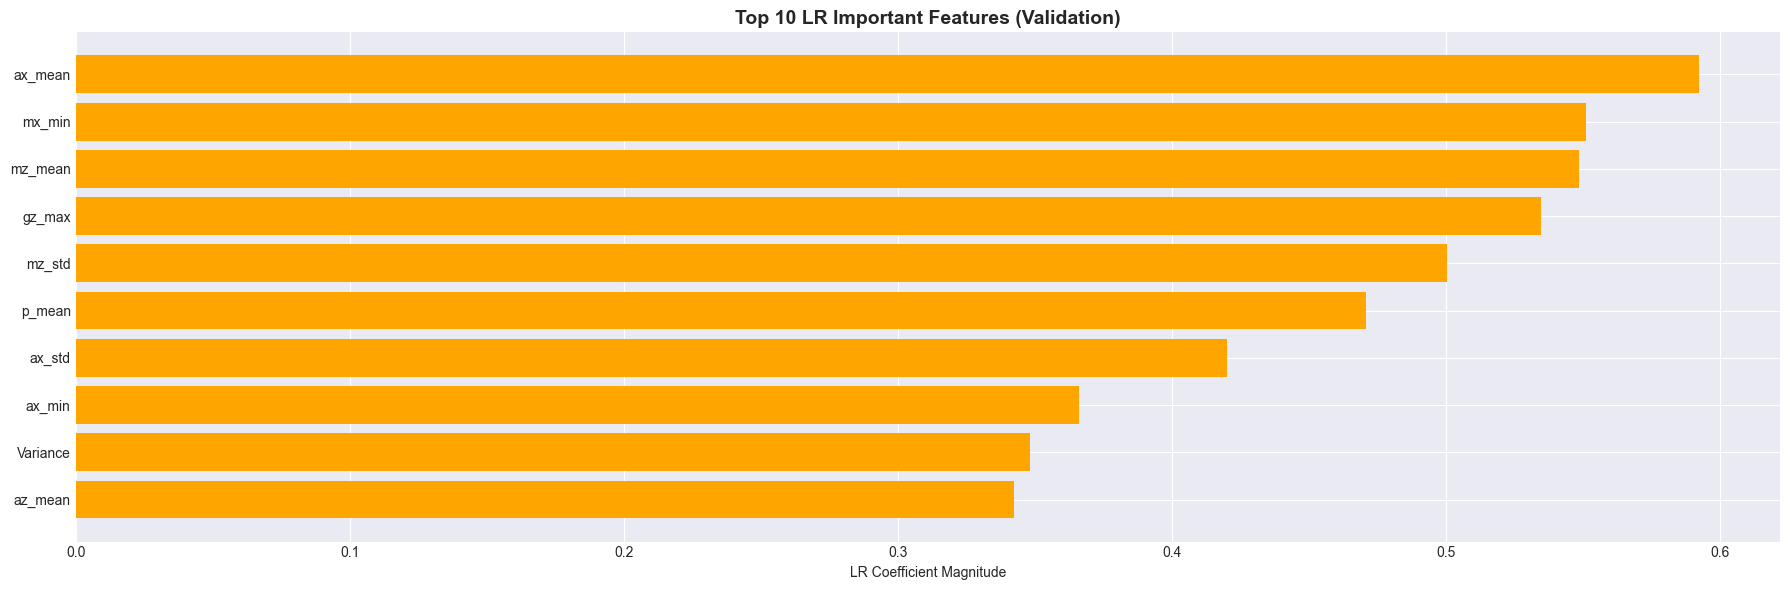

In [29]:
fig, axes = plt.subplots(figsize=(18, 6))

coef_abs = np.abs(model_lr.coef_).mean(axis=0)
top_10_idx_lr = np.argsort(coef_abs)[-10:][::-1]
top_10_scores_lr = coef_abs[top_10_idx_lr]
top_10_names_lr = [all_feature_names[i] for i in top_10_idx_lr]

axes.barh(np.arange(10), top_10_scores_lr, color='orange')
axes.set_yticks(np.arange(10))
axes.set_yticklabels(top_10_names_lr)
axes.invert_yaxis()
axes.set_title('Top 10 LR Important Features (Validation)', fontsize=14, fontweight='bold')
axes.set_xlabel('LR Coefficient Magnitude')

plt.tight_layout()
plt.show()

Confusion Matrices

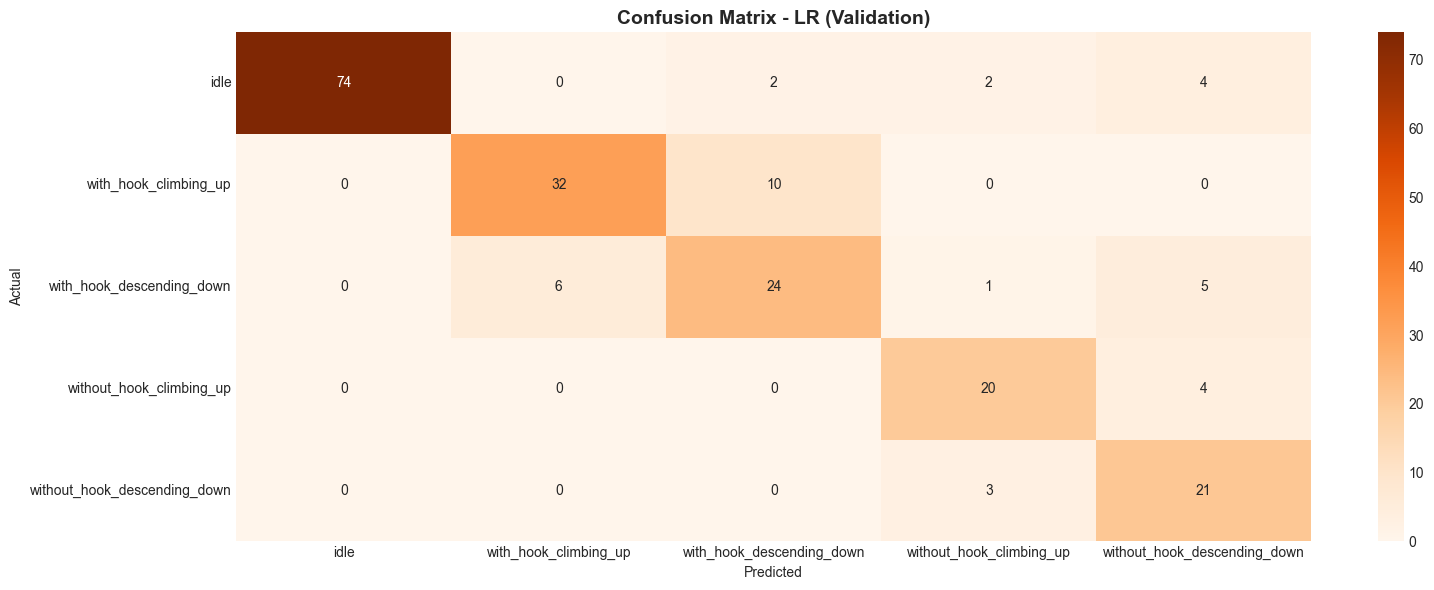

In [30]:
fig, axes = plt.subplots(figsize=(16, 6))

class_names = processor.label_encoder.inverse_transform(model_lr.classes_)

sns.heatmap(cm_lr_val, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes)
axes.set_title('Confusion Matrix - LR (Validation)', fontsize=14, fontweight='bold')
axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Per-Class Performance Metrics

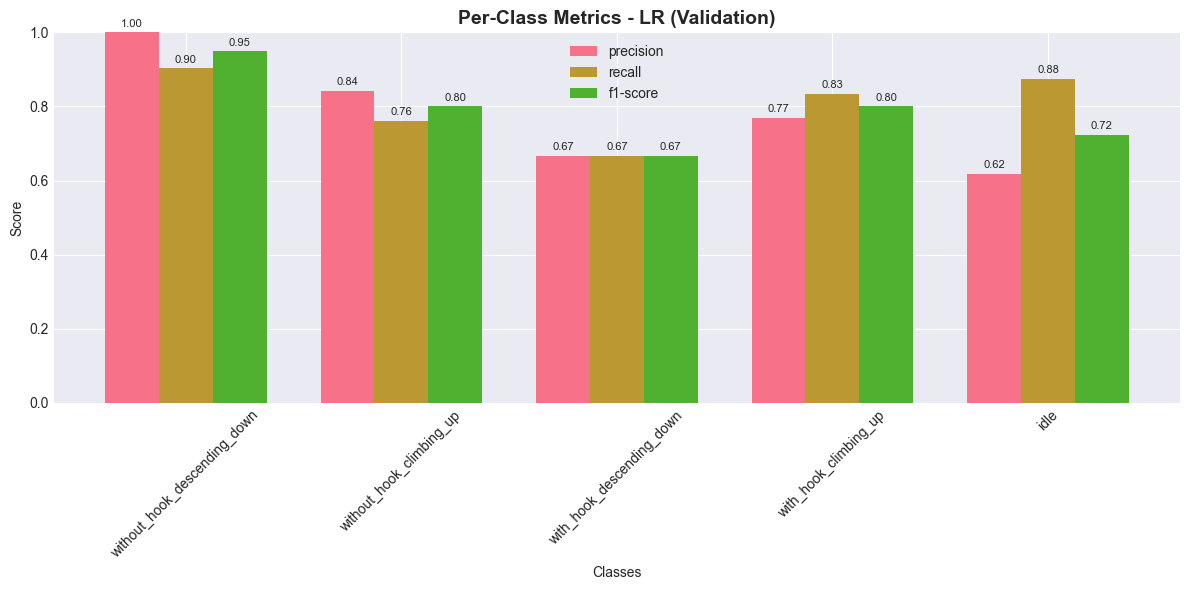

In [31]:
results_df_lr_val.index = results_df_lr_val.index.map(lambda x: int(x) if str(x).isdigit() else x)

index_to_label = {
    0: 'without_hook_descending_down',
    1: 'without_hook_climbing_up',
    2: 'with_hook_descending_down',
    3: 'with_hook_climbing_up',
    4: 'idle'
}

class_indices = list(index_to_label.keys())
class_names = [index_to_label[i] for i in class_indices]

metrics = ['precision', 'recall', 'f1-score']
x_pos = np.arange(len(class_names))

fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    values = [results_df_lr_val.loc[class_idx, metric] for class_idx in class_indices]
    ax.bar(x_pos + i * 0.25, values, width=0.25, label=metric)

    for j, val in enumerate(values):
        ax.text(x_pos[j] + i * 0.25, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8)

ax.set_title("Per-Class Metrics - LR (Validation)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes")
ax.set_ylabel("Score")
ax.set_xticks(x_pos + 0.25)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

Saving Files

In [32]:
# joblib.dump(processor.label_encoder, "model_files/label_encoder.pkl")  
# joblib.dump(model_lr, "model_files/model_lr.pkl")
# joblib.dump(processor.scaler, "model_files/scaler_aggregated.pkl")
# joblib.dump(selector_lr, "model_files/selector_lr.pkl")
# joblib.dump(scaler_lr, "model_files/scaler_lr.pkl")

# size_lr_kb = os.path.getsize("model_files/model_lr.pkl") / 1024
# print(f"Logistic Regression Model Size: {size_lr_kb:.2f} KB")

Live Data Report

In [33]:
import os
import glob  # <-- Add this

DATA_PARENT_DIR = "live_testing_data_F"
VAL_DIRS = ["module1", "module2"]
headers = ["ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz", "p"]
overwrite = False  
output_root = "live_testing_data_" 

for folder in VAL_DIRS:
    input_path = os.path.join(DATA_PARENT_DIR, folder)
    output_path = input_path if overwrite else os.path.join(output_root, folder)
    all_csv_files = glob.glob(os.path.join(input_path, "**/*.csv"), recursive=True)

    for full_input_path in all_csv_files:
        rel_path = os.path.relpath(full_input_path, input_path)
        full_output_path = os.path.join(output_path, rel_path)
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        try:
            df = pd.read_csv(full_input_path, header=None, encoding="ISO-8859-1")

            if df.shape[1] != len(headers):
                print(f"Skipping {rel_path}: expected {len(headers)} columns, got {df.shape[1]}")
                continue

            df.columns = headers
            df.to_csv(full_output_path, index=False, encoding="ISO-8859-1")

        except Exception as e:
            print(f"Error processing {full_input_path}: {e}")

all_batches = []
all_labels = []

val_loader = DataLoader(train_split=0, random_state=38, batch_size=51)

for folder in VAL_DIRS:
    full_path = os.path.join(output_root if not overwrite else DATA_PARENT_DIR, folder)
    val_loader.load_all_data("__dummy__", full_path)
    all_batches.extend(val_loader.all_batches)
    all_labels.extend(val_loader.all_batch_labels)

if not all_batches:
    raise ValueError("No valid batches created from input files.")

X_new = np.vstack(all_batches)
y_true = np.array(all_labels)

print("Shape of X_base:", X_new.shape)
print("Unique true labels:", np.unique(y_true))

X_new_proc_lr, _ = processor.transform_test(X_new, y_true)
X_new_feat_lr = extract_all_features(X_new_proc_lr)
X_new_comb_lr = np.nan_to_num(
    np.column_stack([X_new_proc_lr, X_new_feat_lr]),
    nan=0.0, posinf=1e6, neginf=-1e6
)

X_new_sel_lr = selector_lr.transform(X_new_comb_lr)
X_new_fin_lr = scaler_lr.transform(X_new_sel_lr)

y_pred_lr = model_lr.predict(X_new_fin_lr)
y_true_enc = processor.label_encoder.transform(y_true)

acc_lr = accuracy_score(y_true_enc, y_pred_lr)

print("\nValidation Performance - Logistic Regression")
print(f"Accuracy: {acc_lr:.4f}")
print("Classification Report:")
print(classification_report(y_true_enc, y_pred_lr, digits=4))

cm_lr_liv = confusion_matrix(y_true_enc, y_pred_lr)
classification_rep_lr_val = classification_report(y_true_enc, y_pred_lr, output_dict=True)
results_df_lr_val = pd.DataFrame(classification_rep_lr_val).transpose()

Skipping pred_module1.csv: expected 10 columns, got 2
Skipping pred_module2.csv: expected 10 columns, got 2
Total files: 86
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 15 files, 765 samples
with_hook_climbing_up: 28 files, 1428 samples
with_hook_descending_down: 32 files, 1632 samples
without_hook_climbing_up: 5 files, 255 samples
without_hook_descending_down: 6 files, 306 samples
Total: 86 files, 4386 samples

Creating batches with batch_size=51
File original_test_idle_23062025_110904_idle: 51 samples -> 1 batches
File original_test_idle_23062025_110907_idle: 51 samples -> 1 batches
File original_test_idle_23062025_110909_idle: 51 samples -> 1 batches
File original_test_idle_23062025_110912_idle: 51 samples -> 1 batches
File original_test_idle_23062025_123329_idle: 51 samples -> 1 batches
File original_test_idle_23062025_123332_idle: 51 samples -> 1 batches